In [1]:
source("../00_model-fitting/wwa_model-fitting.R")

## **Maps of return times**

In [27]:
era5 <- read.csv("data/sr-flattened_rx1day_era5.csv", skip = 3, header = F)

colnames(era5)[1] <- "year"
era5 <- merge(read.csv("data/gmst.csv"), era5)

event_gmst <- era5[era5$year == 2023,"gmst"]
y <- which(era5$year == 2023)

In [28]:
# fit GEV over map
system.time({
    mle_gev = lapply(colnames(era5)[-(1:2)], function(cnm) {
        if(is.na(era5[1,cnm])) {
            return(NULL)
        } else {
            return(fit_ns("gev", "fixeddisp", setNames(era5[,c("gmst",cnm)], c("gmst", "pr")), "pr", "gmst", lower = F))
        }
    })
})

In [62]:
ml_rp <- data.frame(t(do.call("rbind", lapply(1:length(mle_gev), function(i) {
    if(is.null(mle_gev[[i]])) {
        return(setNames(rep(NA,1), c("rp")))
    } else {
        mdl <- mle_gev[[i]]
        return(c("rp" = return_period(mdl, mdl$ev, fixed_cov = event_gmst),
               "rdi" = int_change(mdl, rp = 10, cov = event_gmst, cov_cf = event_gmst - 1.2, relative = T)))
    }
}))))
write.csv(ml_rp, file = "res_sr-flattened_rx1day_era5.csv")

## **Return periods for smaller regions**

In [37]:
gmst <- read.csv("data/gmst.csv")
gmst_2023 <- gmst[gmst$year == 2023,"gmst"]

t(sapply(c("era5", "mswep"), function(ds) {
    sapply(c("greece_rx1", "greece_rx2", "greece_rx4", "libya_rx1", "spain_rx1"), function(froot) {
        fnm = list.files("data", pattern = paste0(froot, "day_", ds, ".csv"), full.names = T)
        # print(fnm)
        if(length(fnm) == 0) {
            return(NaN)
        } else {
            df = merge(read.csv("data/gmst.csv"), read.csv(fnm))
            mdl <- fit_ns("gev", "fixeddisp", df, "X0", "gmst", lower = F)
            return(return_period(mdl, mdl$ev, fixed_cov = gmst_2023))
        }
    })
}))

,greece_rx1,greece_rx2,greece_rx4,libya_rx1,spain_rx1
era5,49.85274,223.9648,240.28934,274.291689,36.527190
mswep,63.58857,106.1226,88.22902,3.599429,5.541022


In [39]:
gmst <- read.csv("data/gmst.csv")
gmst_2023 <- gmst[gmst$year == 2023,"gmst"]

res <- sapply(c("greece_rx1", "greece_rx2", "greece_rx4", "libya_rx1", "spain_rx1"), function(froot) {
    fnm = list.files("data", pattern = paste0(froot, "day_era5.csv"), full.names = T)
    # print(fnm)
    if(length(fnm) == 0) {
        return(NaN)
    } else {
        df = merge(read.csv("data/gmst.csv"), read.csv(fnm))
        mdl <- fit_ns("gev", "fixeddisp", df, "X0", "gmst", lower = F)
        return(boot_ci(mdl, gmst_2023, gmst_2023 - 1.2, mdl$ev)["return_period",])
    }
})
round(res)

,greece_rx1,greece_rx2,greece_rx4,libya_rx1,spain_rx1
bestimate,50,224,240,274,37
2.5%,18,53,46,46,16
97.5%,715,1126702,452126,28054787,172


In [40]:
gmst <- read.csv("data/gmst.csv")
gmst_2023 <- gmst[gmst$year == 2023,"gmst"]

res <- sapply(c("greece_rx1", "greece_rx2", "greece_rx4", "libya_rx1", "spain_rx1"), function(froot) {
    fnm = list.files("data", pattern = paste0(froot, "day_mswep.csv"), full.names = T)
    # print(fnm)
    if(length(fnm) == 0) {
        return(NaN)
    } else {
        df = merge(read.csv("data/gmst.csv"), read.csv(fnm))
        mdl <- fit_ns("gev", "fixeddisp", df, "X0", "gmst", lower = F)
        return(boot_ci(mdl, gmst_2023, gmst_2023 - 1.2, mdl$ev)["return_period",])
    }
})
round(res)

,greece_rx1,greece_rx2,greece_rx4,libya_rx1,spain_rx1
bestimate,64,106,88,4,6
2.5%,17,19,17,2,3
97.5%,72219,692210,385845,7,15


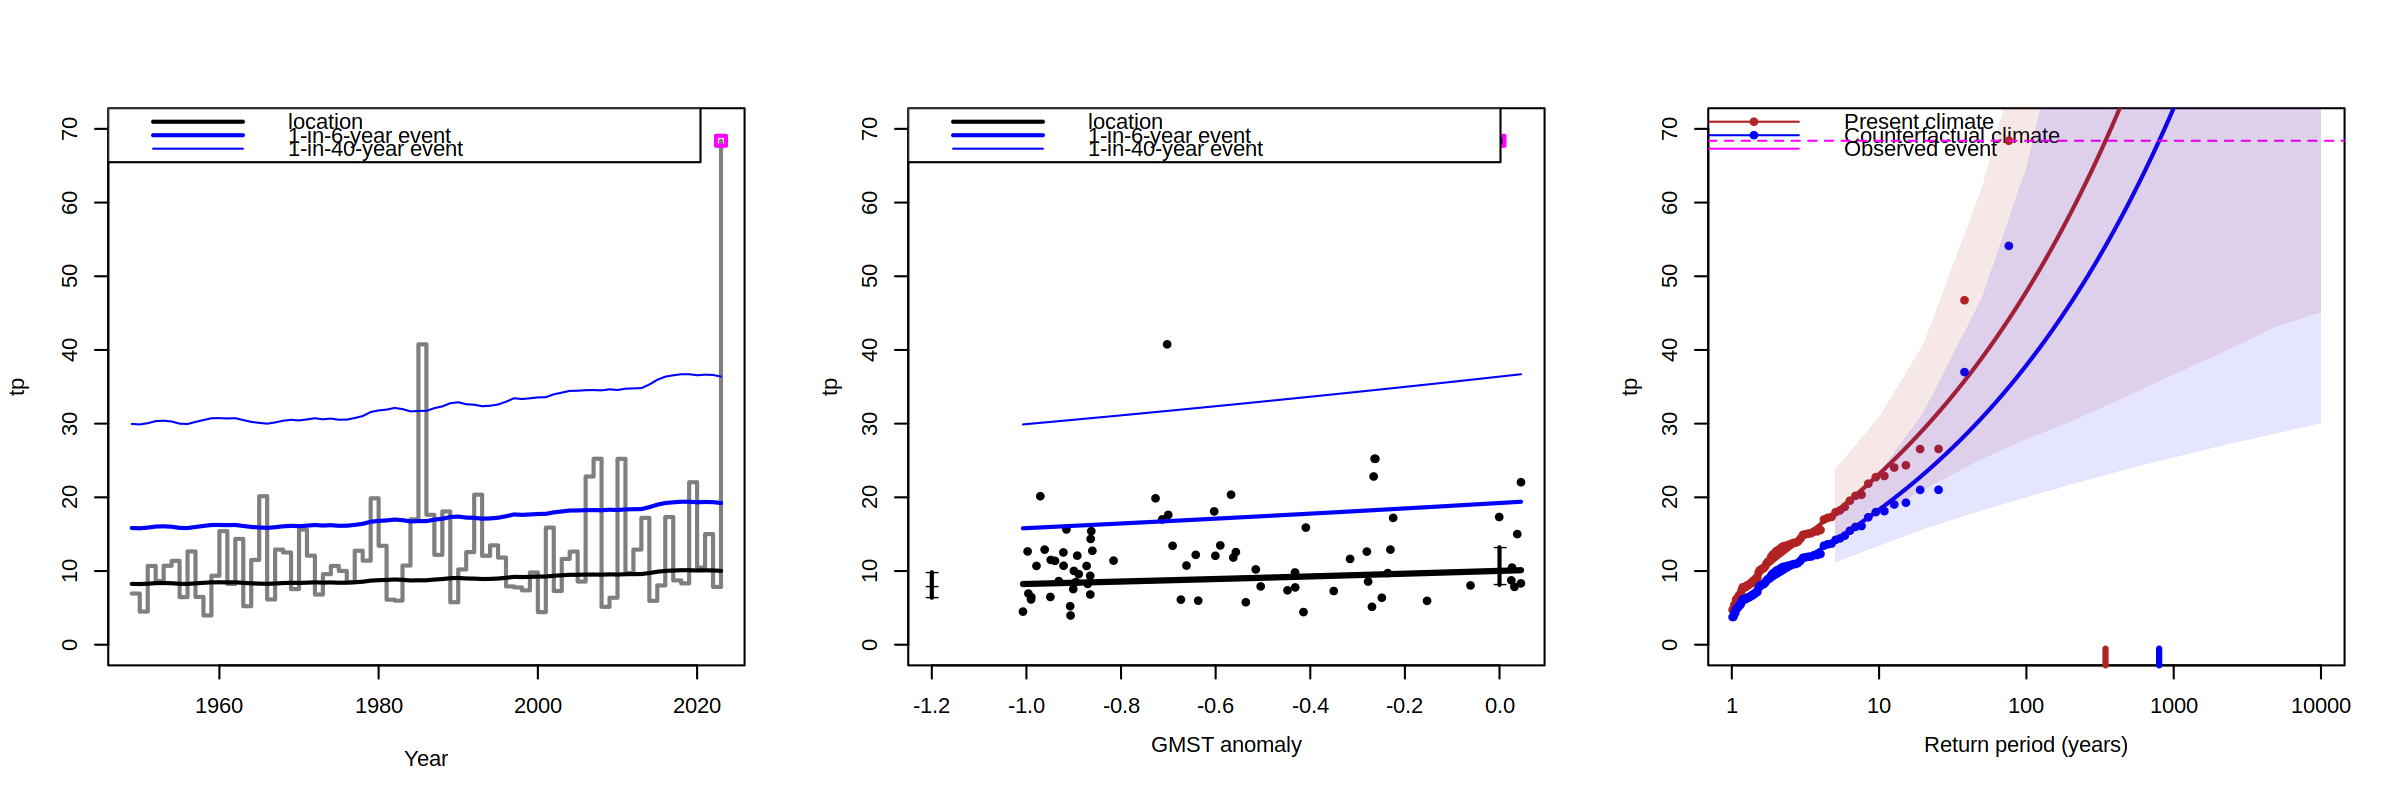

In [25]:
df <- merge(gmst, read.csv("data/era5_libya_rx1day-jj.csv"))
mdl <- fit_ns("gev", "fixeddisp", df, "tp", "gmst", lower = F)

prep_window(c(1,3))
plot_trend(mdl)
plot_gmsttrend(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2)
plot_returnlevels(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2)

### **Thessaly**

In [35]:
res <- t(sapply(c("rx2day", "rx4day"), function(nd) {
# nd <- "rx2day"
    era5_df <- merge(read.csv("data/gmst.csv"), read.csv(paste0("data/thessaly_", nd, "_era5.csv")))
    mswep_df <- merge(read.csv("data/gmst.csv"), read.csv(paste0("data/thessaly_", nd, "_mswep.csv")))

    models <- lapply(list(era5_df, era5_df[era5_df$year >= 1979,], mswep_df), function(df) fit_ns("gev", "fixeddisp", df, "tp", "gmst", lower = F))

    lapply(models, function(mdl) return_period(mdl, mdl$ev, fixed_cov = gmst_2023))
}))
colnames(res) <- c("ERA5", "ERA5_1979", "MSWEP")
res

ERA5     ERA5_1979 MSWEP   
rx2day 172.4243 249.5493  55.33655
rx4day 258.14   424.2753  52.19312

## **Plot for XAIDA brief**

In [18]:
df = merge(read.csv("data/gmst.csv"), load_ts("era5_for_xaida.dat", col.names = c("year", "pr")))

mdl <- fit_ns("gev", "fixeddisp", df, "pr", "gmst", lower = F)

gmst_2023 <- df[df$year == 2023,"gmst"]

In [35]:
jpeg("fig/gbt-rx4day_xaida-brief.jpg", height = 480, width = 480 * 1.3); par(cex = 1.4, mar = c(3.5,3.5,1,1.5), xaxs = "i"); {
    plot_returnlevels(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ylim = c(0,120), legend_pos = "topleft",
                      ylab = "Precipitation (mm/day)")
}; dev.off()

png 
  2